# Ornstein Uhlenbeck calibration by MCMC

The goal is to estimate the parameters of an Ornstein Uhlenbeck model. To do this we will:
+ Implement the Likelihood Function of the OU model : $L(\alpha, \beta, \gamma, x_{t_1}, x_{t_2}, ..., x_{t_n})$
+ Extract data from the simulations implemented in OU_sumulation.ipynb: $x_{t_1}, x_{t_2}, ..., x_{t_n}$
+ Estimate the parameters of the simulation Using an MCMC optimization algorithm

### Likelihood Function

The Ornstein Uhlenbeck process is a Markov Chain. For a sample path $x_0, x_{\frac{T}{N}}, x_{\frac{2T}{N}}, ..., x_T$, the likelihood function is then equal to:

$$L(\alpha, \beta, \gamma, x_0, x_{\frac{T}{N}}, x_{\frac{2T}{N}}, ..., x_T) = \prod_{k=0}^{N-1}{f(x_{\frac{(k+1)T}{N}} | x_{\frac{kT}{N}})}$$
where $f$ is the conditional probability density function of the process.

Given $X_{\frac{kT}{N}}$, the value of the Ornstein Uhlenbeck process at time $\frac{kT}{N}$, $X_{\frac{(k+1)T}{N}}$ is normally distributed with:

$$E(X_{\frac{(k+1)T}{N}} | X_{\frac{kT}{N}}) = X_{\frac{kT}{N}}e^{-\alpha T/N} + \gamma(1-e^{-\beta T/N})$$

$$ Var(X_{\frac{(k+1)T}{N}} | X_{\frac{kT}{N}}) = \frac{\beta^2}{2\alpha}(1-e^{-2\alpha T/N}) $$

Let's denote $E_k$ the previous expectation and $V$ the previous variance (doesn't depend on k). The likelihood function over a sample path $x_0, x_{\frac{T}{N}}, x_{\frac{2T}{N}}, ..., x_T$ of the Ornstein Uhlenbeck process is then equal to:

$$\prod_{k=0}^{N-1}{\frac{1}{\sqrt{2\pi V}} e^{-\frac{(x_{(k+1)T/N} - E_k)^2}{2V}}}$$

Consequently, the negative log likelihood is equal to:

$$NLL(\alpha, \beta, \gamma) = \sum_{k=0}^{N-1}{\frac{(x_{(k+1)T/N} - E_k)^2}{2V} + ln(2\pi V)/2 }$$

which we will minimize to find the parameters $\alpha$, $\beta$ and $\gamma$.

In [1]:
from utils import *

import matplotlib.pyplot as plt
from numpy import exp, log, pi
import numpy as np

def likelihood(T, N, alpha, beta, gamma, path):
    h = T/N
    exp_alpha_h = exp(-alpha*h)
    if type(alpha) is int and alpha == 0:
        V = h*beta**2
    else:
        V = (beta**2)*(1-exp_alpha_h**2)/(2*alpha)
    
    ans = N*log(2*pi*V)/2
    for k in range(N):
        Ek = path[k]*exp_alpha_h + gamma*(1-exp_alpha_h)
        ans += ((path[k+1] - Ek)**2)/(2*V)
    return ans


### Class for the parameters

In [2]:
class OU_Parameters:
    def __init__(self,alpha,beta,gamma) -> None:
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
    
    def __str__(self) -> str:
        s ='\n==== OU Parameters ====\n'
        s+='   alpha : '+str(self.alpha)+'\n'
        s+='   beta  : '+str(self.beta)+'\n'
        s+='   gamma : '+str(self.gamma)+'\n'
        s+='==== OU Parameters ====\n'+'\n'
        return s

### Defintion of the boundaries

In [3]:
minParams = OU_Parameters(alpha=0,beta=1,gamma=1)
maxParams = OU_Parameters(alpha=0.1,beta=3,gamma=5)

# alphaBoundaries = (0 , 0.1)
# betaBoundaries  = (1 , 3  )
# gammaBoundaries = (1 , 5  )

### Code for estimation plot

In [4]:
def estimation_plot(T,N,x0,params,traceParams,paramToPlot):
    plt.figure() 
    path = OU_process(T, N, x0, params.alpha, params.beta, params.gamma)

    if paramToPlot == 'alpha':
        NLL = likelihood(T, N, traceParams, params.beta, params.gamma, path)
    elif paramToPlot == 'beta':
        NLL = likelihood(T, N, params.alpha, traceParams, params.gamma, path)
    elif paramToPlot == 'gamma':
        NLL = likelihood(T, N, params.alpha, params.beta, traceParams, path)
        
    plt.plot(traceParams, NLL)
    plt.show()

### Estimating $\alpha$
+ $x_0$ should be far from $\gamma$

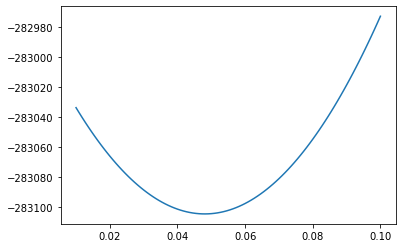

In [5]:
estimation_plot(
    T = 50, 
    N = 100000, 
    x0 = 100,
    params = OU_Parameters(alpha=0.05,beta = 1,gamma = 3),
    traceParams = np.linspace(0.01, 0.1, 100),
    paramToPlot='alpha')

### Estimating $\beta$
+ $T$ should be small (to focus on the first steps of the process)
+ $\beta > 0$ 

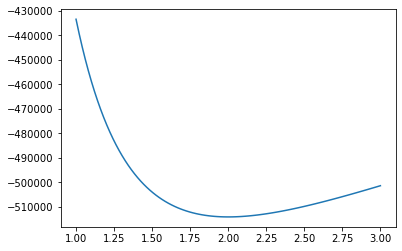

In [6]:
beta = 2
estimation_plot(
    T = 0.05, 
    N = 100000, 
    x0 = 100,
    params = OU_Parameters(alpha=0.05,beta = beta,gamma = 0),
    traceParams = np.linspace(beta-1, beta + 1,100),
    paramToPlot='beta')

### Estimating $\gamma$
+ $T$ should be large enough, to allow the process to converge to $\gamma$

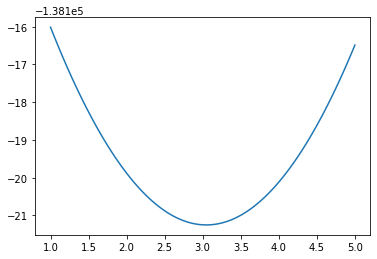

In [7]:
gamma = 3
estimation_plot(
    T = 1000, 
    N = 100000, 
    x0 = 0,
    params = OU_Parameters(alpha=0.05,beta = 1,gamma = gamma),
    traceParams = np.linspace(gamma-2, gamma+2, 100),
    paramToPlot='gamma')

## Estimating all parameters with Metropolis-Hastings

### Definition of the Markov transition in 2D

In [8]:
import random 
def MarkovTransition(param): 
    r = random.random()
    alpha1 = max(minParams.alpha,min(maxParams.alpha,param.alpha + 2*(r-0.5)*(maxParams.alpha-minParams.alpha)/100))  # uniform distribution on [alpha - alphaBoundaries/10;alpha + alphaBoundaries/10]
    r = random.random()
    
    gamma1 = max(minParams.gamma,min(maxParams.gamma,param.gamma + 2*(r-0.5)*(maxParams.gamma-minParams.gamma)/100))
    return OU_Parameters(alpha1,param.beta,gamma1)

### Metropolis Hastings algorithm

In [82]:
from tqdm import tqdm
from math import inf

def OU_metropolis_mcmc(n,T,N,path,Xs=None):
    if Xs is None:
        Xs = OU_Parameters(  alpha = minParams.alpha + random.random()*(maxParams.alpha-minParams.alpha),
                        beta = minParams.beta + random.random()*(maxParams.beta-minParams.beta) ,
                        gamma = minParams.gamma + random.random()*(maxParams.gamma-minParams.gamma))
    
    BestX = None
    bestNLL = inf
    samples = [Xs]
    NLLs = [likelihood(T,N,Xs.alpha,Xs.beta,Xs.gamma,path)]

    for _ in tqdm(range(n)):
        xi = samples[-1]
        x = MarkovTransition(xi)
        NLL = likelihood(T,N,x.alpha,x.beta,x.gamma,path)
        if NLL<bestNLL:
            bestNLL=NLL,
            BestX=xi

        # Computing alpha
        if (NLLs[-1]*NLL < 0):                  # stay on the negative side of the likelihood
            if NLL < 0:
                alpha=1
            else:
                alpha=0
        else:                                   # NLLs[-1] and NLL have the same sign
            if NLL < 0:
                alpha = NLL/NLLs[-1]
            else:
                alpha = NLLs[-1]/NLL
                
        # deciding next sample
        u = random.random()
        if u < alpha:
            samples.append(x)
            NLLs.append(NLL)
        else:
            samples.append(xi)
            NLLs.append(NLLs[-1])
    return samples,NLLs,BestX,bestNLL

## Distribution estimation 

In [ ]:

minParams = OU_Parameters(alpha=0,beta=0.45,gamma=0)
maxParams = OU_Parameters(alpha=0.1,beta=1.5,gamma=20)
paramsToFind = OU_Parameters(alpha=0.05,beta=1,gamma=10)
n = 10**5
T = 2000
N = 1000
x0 = 300
samples,NLLs,estimatedParam,NLL = OU_metropolis_mcmc(n    = n,
                                                T    = T,
                                                N    = N,
                                                Xs   = OU_Parameters(alpha=0.02,beta=1.75,gamma=2),
                                                path = OU_process(  T     = T,
                                                                    N     = N,
                                                                    x0    = x0, 
                                                                    alpha = paramsToFind.alpha,
                                                                    beta  = paramsToFind.beta,
                                                                    gamma = paramsToFind.gamma))


In [96]:
print('Expected parameters')
print(paramsToFind)
print('Estimated parameters')
print(estimatedParam)

Expected parameters

==== OU Parameters ====
   alpha : 0.05
   beta  : 1
   gamma : 10
==== OU Parameters ====


Estimated parameters

==== OU Parameters ====
   alpha : 0.052434689388794614
   beta  : 1.75
   gamma : 10.124750121383247
==== OU Parameters ====




### Likelihood contour plot

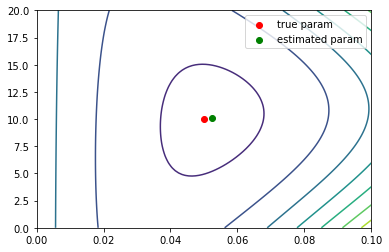

In [97]:
np.seterr(divide='ignore', invalid='ignore')
minParams = OU_Parameters(alpha=0,beta=0.45,gamma=0)
maxParams = OU_Parameters(alpha=0.1,beta=1.5,gamma=20)
paramsToFind = OU_Parameters(alpha=0.05,beta=1,gamma=10)

n = 100
x0 = 300
N = 10000
T = 3000
alphas = np.linspace(minParams.alpha, maxParams.alpha, n)
beta = paramsToFind.beta
gammas = np.linspace(minParams.gamma, maxParams.gamma, n)
path = OU_process(T, N, x0, paramsToFind.alpha, paramsToFind.beta, paramsToFind.gamma)

As, Gs = np.meshgrid(alphas, gammas)
Ls = likelihood(T, N, As, beta, Gs, path)
plt.contour(As, Gs, Ls)
plt.scatter(paramsToFind.alpha, paramsToFind.gamma, color = "red", label="true param")
plt.scatter(estimatedParam.alpha, estimatedParam.gamma, color="green", label="estimated param")
plt.legend()